# Title: Predicting Company Bankruptcy Using Financial Data
# Objective: To analyze financial data to predict the likelihood of company bankruptcy.

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import scipy
import scipy.stats
from scipy import stats
from scipy.stats import norm,t


from imblearn.over_sampling import SMOTE
import statsmodels
from statsmodels import stats
from statsmodels.stats import  weightstats

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from statsmodels.stats import proportion

from scipy.stats import chisquare

import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt
import pylab
from pylab import plot,show,legend,title,xlabel,ylabel

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
## 1. Data Understanding and Preprocessing:
o Load and inspect the dataset.
o Handle missing values appropriately.
o Detect and handle outliers.

In [2]:
df = pd.read_csv(r'C:\Users\User\Downloads\exam_data.csv')

In [3]:
df.head(5)

Bankrupt?   ROA(C) before interest and depreciation before interest  \
0          1                                           0.370594          
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax  \
0                                 0.424389   
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax  \
0                                           0.405750    
1                                           0.516730    
2                                           0.472295    
3                                           0.457733    
4                                           0.522298    

    Operating Gross Margin   Realized Sales Gross Margin  \
0                 0.601457                      0.601457   
1                 0.610235                      0.610235   
2                 0.601450                      0.601364   
3                 0.583541                      0.583541   
4                 0.598783                      0.598783   

    Operating Profit Rate   Pre-tax net Interest Rate  \
0                0.998969                    0.796887   
1                0.998946                    0.797380   
2                0.998857                    0.796403   
3                0.998700                    0.796967   
4                0.998973                    0.797366   

    After-tax net Interest Rate   Non-industry income and expenditure/revenue  \
0                      0.808809                                      0.302646   
1                      0.809301                                      0.303556   
2                      0.808388                                      0.302035   
3                      0.808966                                      0.303350   
4                      0.809304                                      0.303475   

   ...   Net Income to Total Assets   Total assets to GNP price  \
0  ...                     0.716845                    0.009219   
1  ...                     0.795297                    0.008323   
2  ...                     0.774670                    0.040003   
3  ...                     0.739555                    0.003252   
4  ...                     0.795016                    0.003878   

    No-credit Interval   Gross Profit to Sales  \
0             0.622879                0.601453   
1             0.623652                0.610237   
2             0.623841                0.601449   
3             0.622929                0.583538   
4             0.623521                0.598782   

    Net Income to Stockholder's Equity   Liability to Equity  \
0                             0.827890              0.290202   
1                             0.839969              0.283846   
2                             0.836774              0.290189   
3                             0.834697              0.281721   
4                             0.839973              0.278514   

    Degree of Financial Leverage (DFL)  \
0                             0.026601   
1                             0.264577   
2                             0.026555   
3                             0.026697   
4                             0.024752   

    Interest Coverage Ratio (Interest expense to EBIT)   Net Income Flag  \
0                                           0.564050                   1   
1                                           0.570175                   1   
2                                           0.563706                   1   
3                                           0.564663                   1   
4                        

In [4]:
df.shape

(6819, 96)

In [5]:
pd.set_option('display.max_columns',300) # This will display maximum 500 Columns
pd.set_option('display.max_rows',300) # This will display maximum 500 Rows

# ---Rename Columns----

In [6]:
df.columns = df.columns.str.replace(' ','')

In [7]:
df.columns = df.columns.str.replace('/','_')

In [8]:
df.columns = df.columns.str.replace('?','')

In [9]:
df.columns = df.columns.str.replace('-','_')

In [10]:
df.columns = df.columns.str.replace('%','_')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Bankrupt                                           6819 non-null   int64  
 1   ROA(C)beforeinterestanddepreciationbeforeinterest  6819 non-null   float64
 2   ROA(A)beforeinterestand_aftertax                   6819 non-null   float64
 3   ROA(B)beforeinterestanddepreciationaftertax        6819 non-null   float64
 4   OperatingGrossMargin                               6819 non-null   float64
 5   RealizedSalesGrossMargin                           6819 non-null   float64
 6   OperatingProfitRate                                6819 non-null   float64
 7   Pre_taxnetInterestRate                             6819 non-null   float64
 8   After_taxnetInterestRate                           6819 non-null   float64
 9   Non_indu

In [12]:
df.shape

(6819, 96)

In [13]:
columns_drop = ['NetIncomeFlag','Liability_AssetsFlag','Bankrupt',]
new_df=df.drop(columns=columns_drop)
#this is catogorical data column that's why we drop 

# check Outliers

In [14]:
# Function to detect outliers using IQR for all columns
def detect_outliers_iqr(new_df):
    outliers = {}
    for column in new_df.columns:
        if new_df[column].dtype != 'object':  # Ensure the column is numerical
            Q1 = new_df[column].quantile(0.25)
            Q3 = new_df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[column] = new_df[(new_df[column] < lower_bound) | (new_df[column] > upper_bound)]
    return outliers

print("================================================================================")

# Detect outliers in all columns
outliers = detect_outliers_iqr(new_df)

# Print the number of outliers for each feature

count = 0

for feature, outlier_data in outliers.items():
    print(f'{feature}: {len(outlier_data)} outliers')
    if len(outlier_data) > 0:
        count+=1

print("=============================================================================================")
    
# Function to cap outliers for all columns using IQR
def cap_outliers(new_df):
    for column in new_df.columns:
        if new_df[column].dtype != 'object':  # Ensure the column is numerical
            Q1 = new_df[column].quantile(0.25)
            Q3 = new_df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            new_df[column] = np.where(new_df[column] < lower_bound, lower_bound, new_df[column])
            new_df[column] = np.where(new_df[column] > upper_bound, upper_bound, new_df[column])
    return new_df

# Handle outliers in all columns
data_cleaned = cap_outliers(new_df)

# Verify the changes

print("----------------------------------------------------------------------------")

print("Outliers have been capped.")
data_cleaned.describe()

print("------------------------------------------------------------------------------")
print("Outlier Found In : ",count,"  Column")

ROA(C)beforeinterestanddepreciationbeforeinterest: 391 outliers
ROA(A)beforeinterestand_aftertax: 561 outliers
ROA(B)beforeinterestanddepreciationaftertax: 432 outliers
OperatingGrossMargin: 320 outliers
RealizedSalesGrossMargin: 318 outliers
OperatingProfitRate: 716 outliers
Pre_taxnetInterestRate: 773 outliers
After_taxnetInterestRate: 867 outliers
Non_industryincomeandexpenditure_revenue: 1094 outliers
Continuousinterestrate(aftertax): 806 outliers
OperatingExpenseRate: 0 outliers
Researchanddevelopmentexpenserate: 182 outliers
Cashflowrate: 576 outliers
Interest_bearingdebtinterestrate: 396 outliers
Taxrate(A): 120 outliers
NetValuePerShare(B): 457 outliers
NetValuePerShare(A): 464 outliers
NetValuePerShare(C): 465 outliers
PersistentEPSintheLastFourSeasons: 508 outliers
CashFlowPerShare: 532 outliers
RevenuePerShare(Yuan¥): 478 outliers
OperatingProfitPerShare(Yuan¥): 442 outliers
PerShareNetprofitbeforetax(Yuan¥): 511 outliers
RealizedSalesGrossProfitGrowthRate: 814 outliers
Oper

In [15]:
df.shape

(6819, 96)

2. Exploratory Data Analysis (EDA):
o Generate descriptive statistics.
o Visualize feature distributions and target variable.
o Analyze relationships between features and the target variable.

In [16]:
# Generate descriptive statistics
df.describe()


Bankrupt  ROA(C)beforeinterestanddepreciationbeforeinterest  \
count  6819.000000                                        6819.000000   
mean      0.032263                                           0.505180   
std       0.176710                                           0.060686   
min       0.000000                                           0.000000   
25%       0.000000                                           0.476527   
50%       0.000000                                           0.502706   
75%       0.000000                                           0.535563   
max       1.000000                                           1.000000   

       ROA(A)beforeinterestand_aftertax  \
count                       6819.000000   
mean                           0.558625   
std                            0.065620   
min                            0.000000   
25%                            0.535543   
50%                            0.559802   
75%                            0.589157   
max                            1.000000   

       ROA(B)beforeinterestanddepreciationaftertax  OperatingGrossMargin  \
count                                  6819.000000           6819.000000   
mean                                      0.553589              0.607948   
std                                       0.061595              0.016934   
min                                       0.000000              0.000000   
25%                                       0.527277              0.600445   
50%                                       0.552278              0.605997   
75%                                       0.584105              0.613914   
max                                       1.000000              1.000000   

       RealizedSalesGrossMargin  OperatingProfitRate  Pre_taxnetInterestRate  \
count               6819.000000          6819.000000             6819.000000   
mean                   0.607929             0.998755                0.797190   
std                    0.016916             0.013010                0.012869   
min                    0.000000             0.000000                0.000000   
25%                    0.600434             0.998969                0.797386   
50%                    0.605976             0.999022                0.797464   
75%                    0.613842             0.999095                0.797579   
max                    1.000000             1.000000                1.000000   

       After_taxnetInterestRate  Non_industryincomeandexpenditure_revenue  \
count               6819.000000                               6819.000000   
mean                   0.809084                                  0.303623   
std                    0.013601                                  0.011163   
min                    0.000000                                  0.000000   
25%                    0.809312                                  0.303466   
50%                    0.809375                                  0.303525   
75%                    0.809469                                  0.303585   
max                    1.000000                                  1.000000   

       Continuousinterestrate(aftertax)  OperatingExpenseRate  \
count                       6819.000000          6.819000e+03   
mean                           0.781381          1.995347e+09   
std                            0.012679          3.237684e+09   
min                            0.000000          0.000000e+00   
25%                            0.781567          1.566874e-04   
50%                            0.781635          2.777589e-04   
75%                            0.781735          4.145000e+09   
max                            1.000000          9.990000e+09   

       Researchanddevelopmentexpenserate  Cashflowrate  \
count                       6.819000e+03   6819.000000   
mean                        1.950427e+09      0.467431   
std                         2.598292e+09      0.017036   
min                         0.000000e+00      

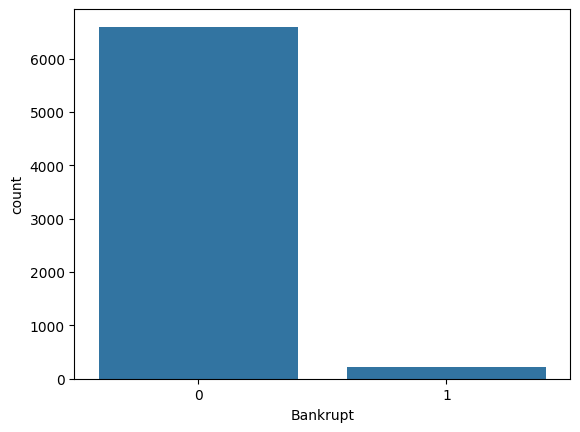

In [17]:
# Plot the distribution of the target variable
sns.countplot(x='Bankrupt', data=df)
plt.show()

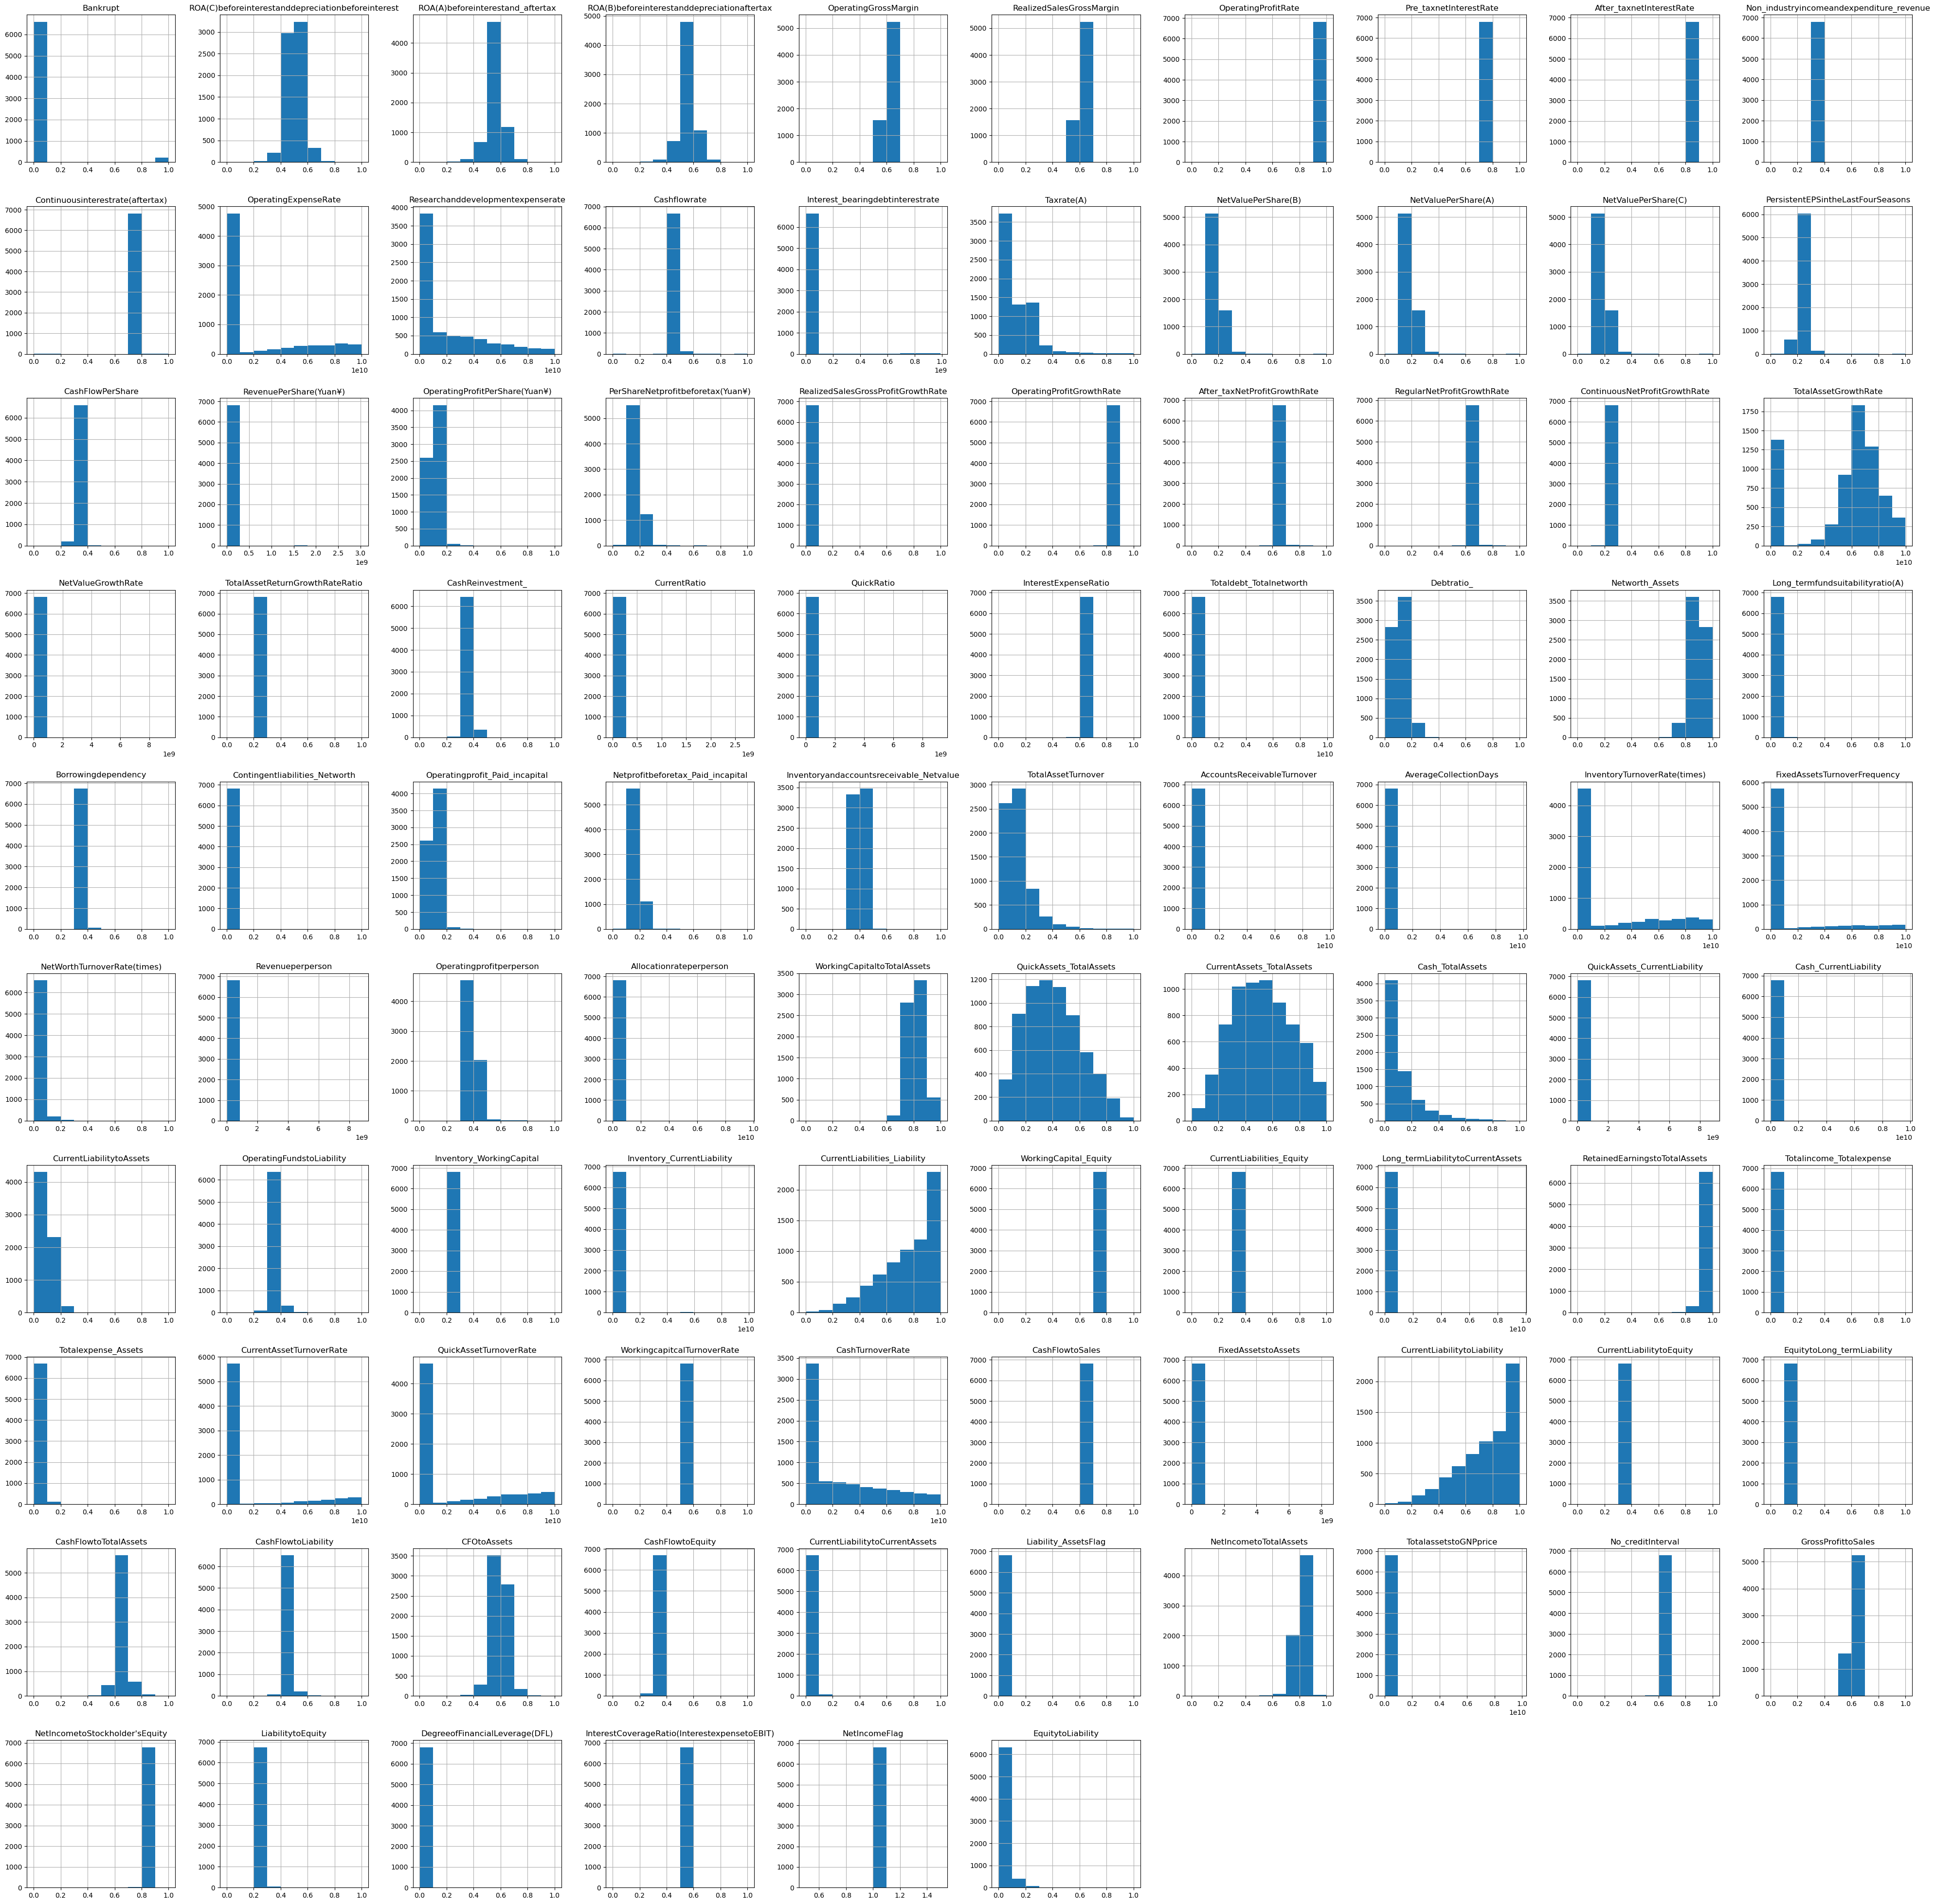

In [123]:
# Plot the distribution of features
df.hist(figsize=(50, 50))
plt.show()

In [18]:
 #we will use correlation matrices and pair plots to analyze relationships.
# Compute the correlation matrix
correlation_matrix = df.corr()


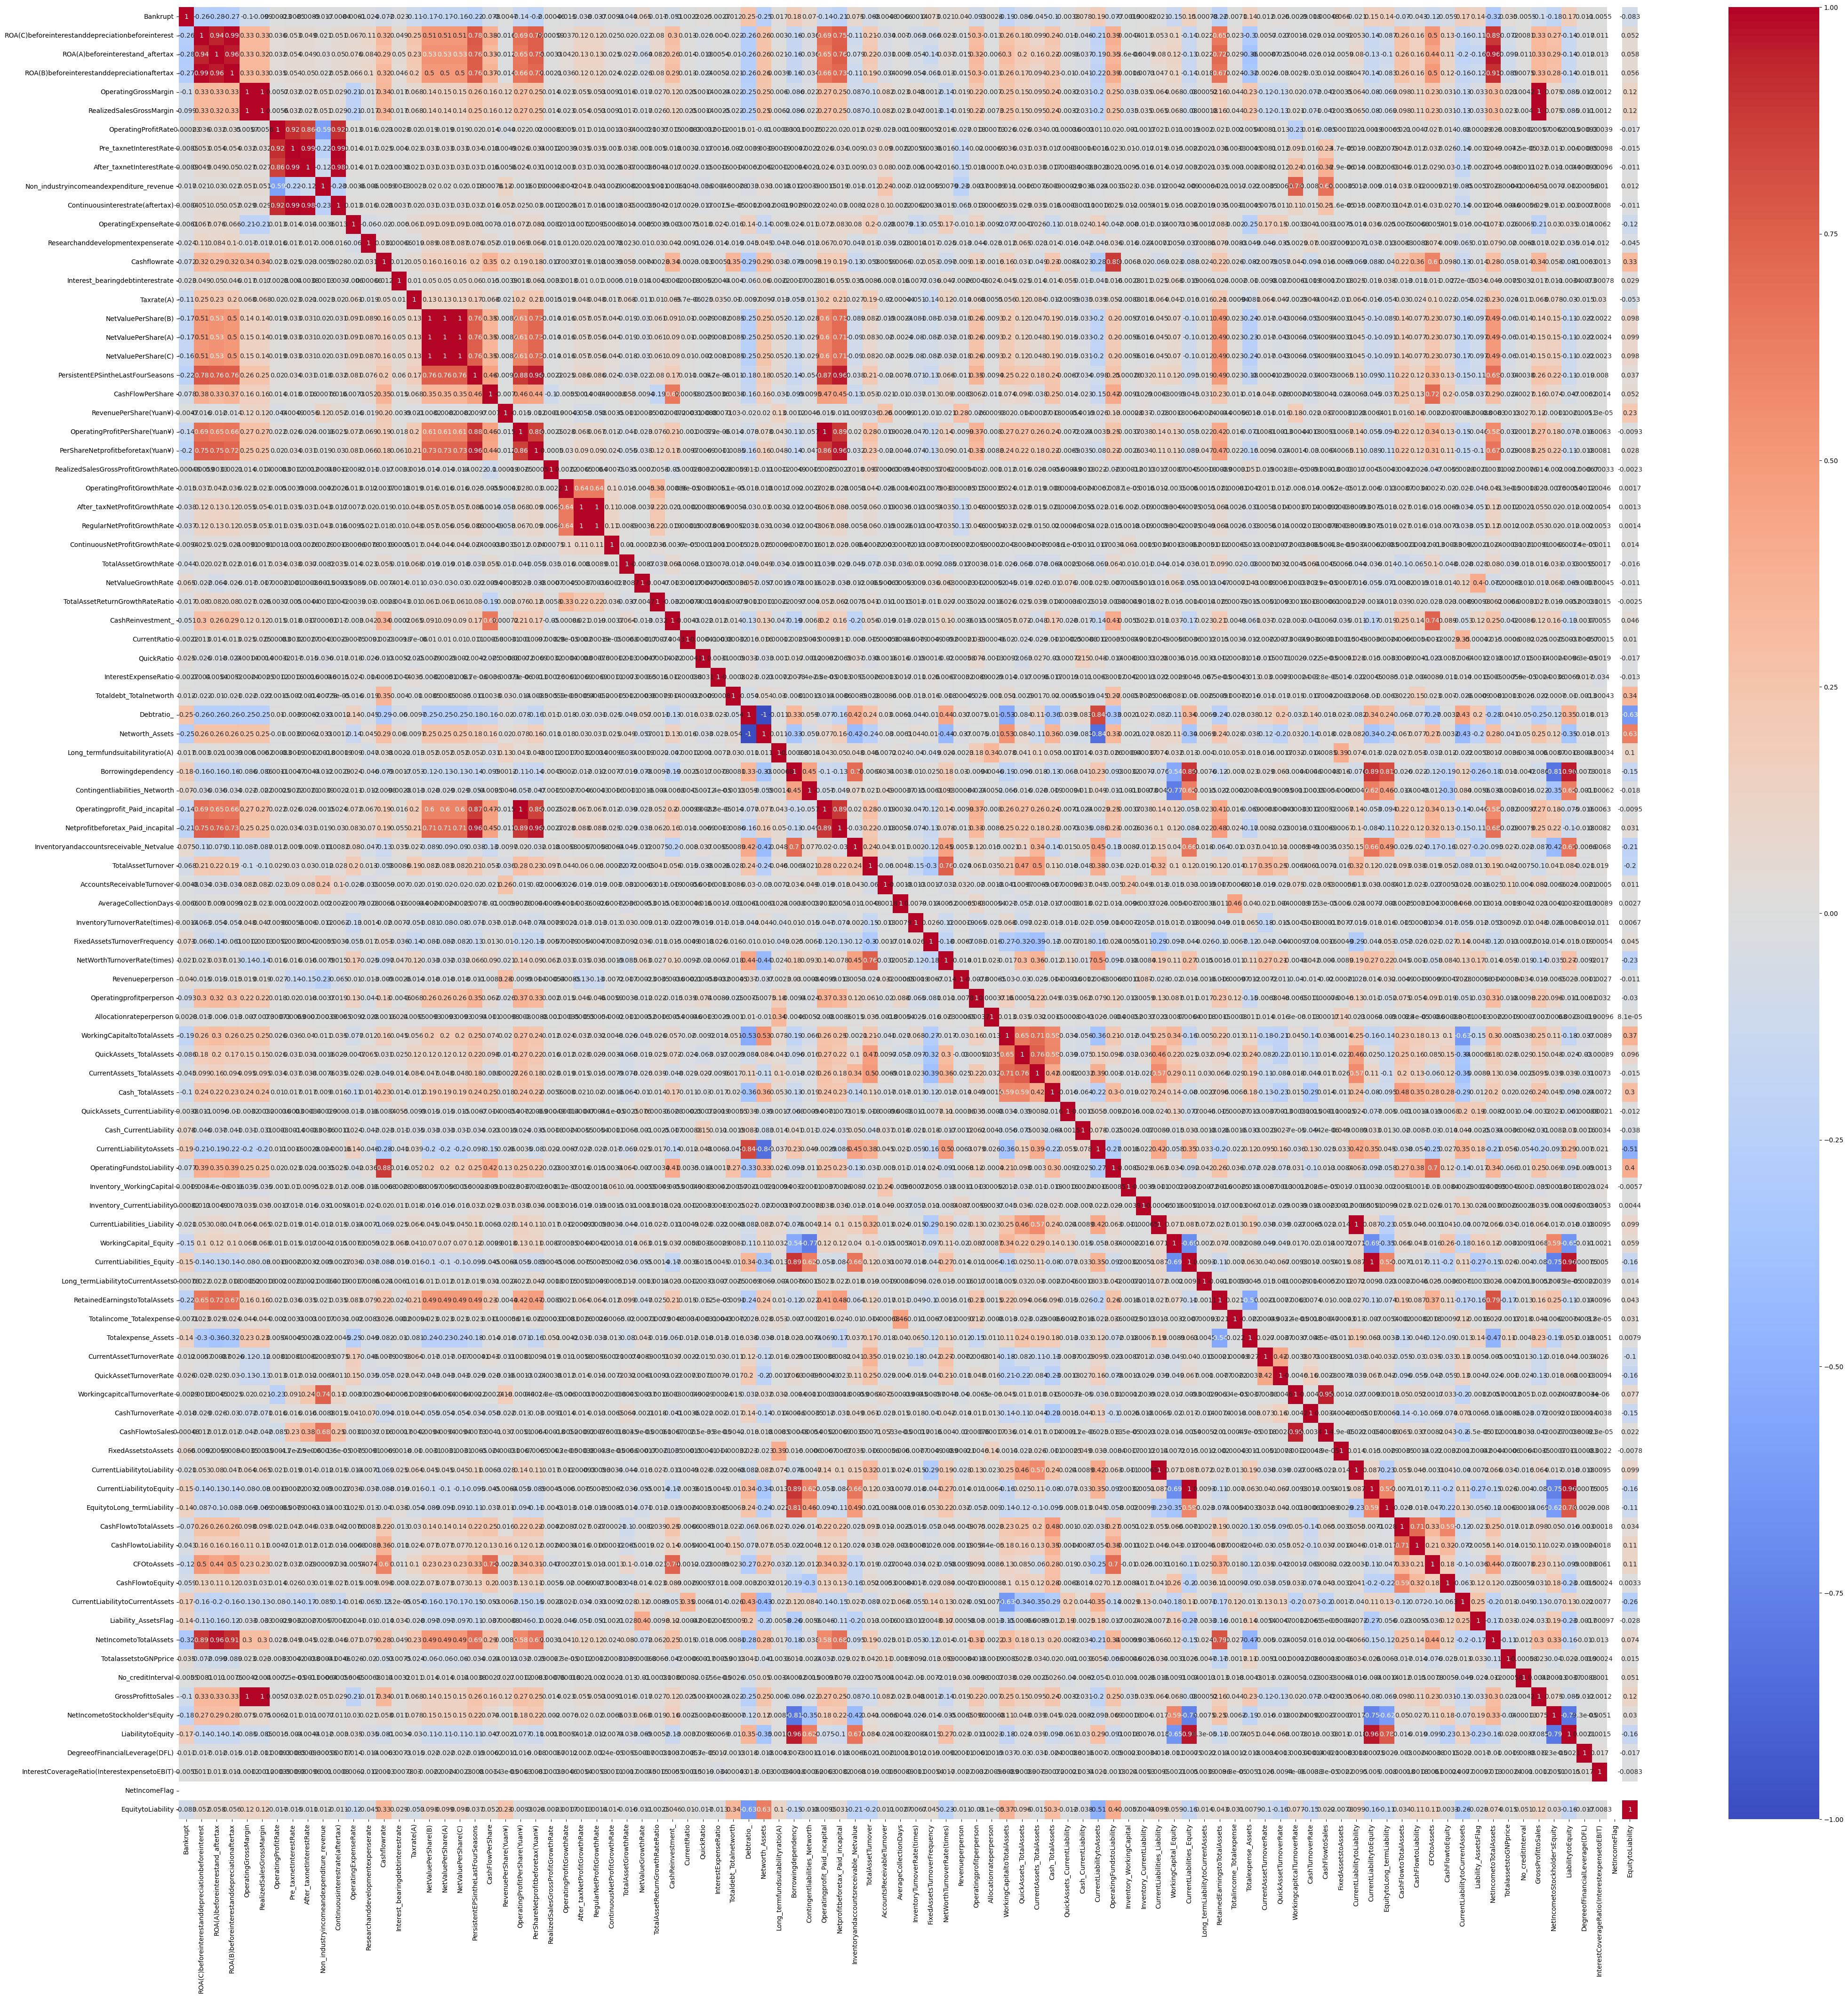

In [19]:
# Plot the heatmap of correlations
plt.figure(figsize=(50, 50))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

3. Hypothesis Testing:
o Perform hypothesis testing to identify significant features influencing bankruptcy.

In [23]:
# Perform t-tests for each feature
significant_features = []
for column in df.columns[:-1]:  # Exclude the target variable
    t_stat, p_value = scipy.stats.ttest_ind(df[column][df['Bankrupt'] == 1], df[column][df['Bankrupt'] == 0],equal_var=False)
    if p_value < 0.05:
        significant_features.append(column)


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [24]:
print(significant_features)

['Bankrupt', 'ROA(C)beforeinterestanddepreciationbeforeinterest', 'ROA(A)beforeinterestand_aftertax', 'ROA(B)beforeinterestanddepreciationaftertax', 'OperatingGrossMargin', 'RealizedSalesGrossMargin', 'Pre_taxnetInterestRate', 'After_taxnetInterestRate', 'Non_industryincomeandexpenditure_revenue', 'Continuousinterestrate(aftertax)', 'Researchanddevelopmentexpenserate', 'Cashflowrate', 'Interest_bearingdebtinterestrate', 'Taxrate(A)', 'NetValuePerShare(B)', 'NetValuePerShare(A)', 'NetValuePerShare(C)', 'PersistentEPSintheLastFourSeasons', 'CashFlowPerShare', 'RevenuePerShare(Yuan¥)', 'OperatingProfitPerShare(Yuan¥)', 'PerShareNetprofitbeforetax(Yuan¥)', 'After_taxNetProfitGrowthRate', 'RegularNetProfitGrowthRate', 'TotalAssetGrowthRate', 'TotalAssetReturnGrowthRateRatio', 'Debtratio_', 'Networth_Assets', 'Borrowingdependency', 'Operatingprofit_Paid_incapital', 'Netprofitbeforetax_Paid_incapital', 'Inventoryandaccountsreceivable_Netvalue', 'TotalAssetTurnover', 'AverageCollectionDays', '

4. Feature Engineering and Selection:
o Create new features to enhance predictive power.
o Use dimensionality reduction techniques if necessary.
o Select relevant features using methods like RFE or feature importance.

In [54]:

model = LogisticRegression()
# RFE object and 10 features
r = RFE(model, n_features_to_select=10)
r = r.fit(df.drop("Bankrupt", axis=1), df["Bankrupt"])
feature = df.columns[:-1][r.support_]
print(feature)

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

Index(['Cashflowrate', 'CashFlowPerShare', 'TotalAssetGrowthRate',
       'CashReinvestment_', 'TotalAssetTurnover', 'AccountsReceivableTurnover',
       'NetWorthTurnoverRate(times)', 'Operatingprofitperperson',
       'Cash_TotalAssets', 'CashFlowtoSales'],
      dtype='object')


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5. Modeling:
o Split the data into training and testing sets.
o Apply Logistic Regression for classification.
o Evaluate model performance using appropriate metrics.

In [45]:
from sklearn.model_selection import train_test_split

# Split --> data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[feature], df['Bankrupt'], test_size=0.2, random_state=42)

# Train -->  logistic regression model on the training data
model.fit(X_train, y_train)

#  coefficients
coefficients = pd.DataFrame(model.coef_.T, index=feature, columns=['Coefficient'])

# coefficients in descending order
print(coefficients.sort_values(by='Coefficient', ascending=False))

                              Coefficient
NetWorthTurnoverRate(times) -3.007993e-18
TotalAssetTurnover          -1.198461e-17
Cash_TotalAssets            -1.219417e-17
CashFlowPerShare            -2.139234e-17
CashReinvestment_           -2.503019e-17
Operatingprofitperperson    -2.706712e-17
Cashflowrate                -3.085801e-17
CashFlowtoSales             -4.431952e-17
TotalAssetGrowthRate        -5.616880e-10
AccountsReceivableTurnover  -5.984914e-10


              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1313
           1       0.00      0.00      0.00        51

    accuracy                           0.96      1364
   macro avg       0.48      0.50      0.49      1364
weighted avg       0.93      0.96      0.94      1364

Accuracy: 0.9626099706744868
[[1313    0]
 [  51    0]]


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

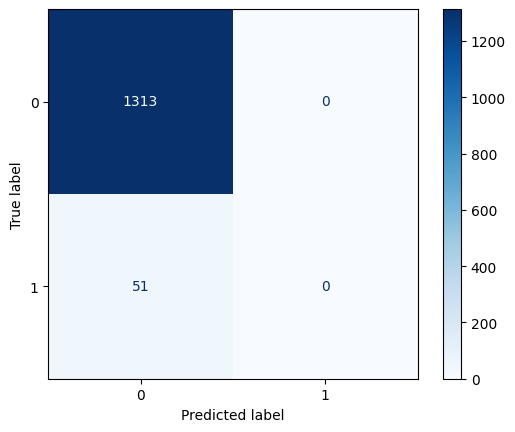

In [53]:

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# Predict -->  test set
y_pred = model.predict(X_test)

# model
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# confusion matrix
cm = confusion_matrix(y_test, y_pred)

# confusion matrix
print(cm)

# visualize --> confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()
